In [32]:
import gym
from helpers import NormalizedEnv, RandomAgent
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from mpl_toolkits.mplot3d import Axes3D
from pylab import*
import os

## 3. Heuristic Policy

In [33]:
# Implement a heuristic policy
class HeuristicPendulumAgent():
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.agent_name='HeuristicPendulumAgent'

    def get_agent_name(self):
        return self.agent_name

    def compute_action(self, state,fix_torque=0.1):
         # When the pendulum is in the lower half of the domain (x<0)
         if state[0]<0:
             # applies a fixed torque in the same direction as the pendulum’s angular velocity
             return fix_torque*np.sign(state[2])
         # When the pendulum is in the higher half of the domain (x>0)
         else:
             # applies a fixed torque in the  opposite direction as the pendulum’s angular velocity
             return -1*fix_torque*np.sign(state[2])

In [34]:
def DoState(env,agent,observation,total_reward_per_episode,agent_name='RandomAgent',fix_torque=0.1):
    if agent_name=='HeuristicPendulumAgent':
        action = agent.compute_action(observation,fix_torque)
    else:
        action = agent.compute_action(observation)
    # print('action:',action)
    normalized_env = NormalizedEnv(env)
    normalized_action = normalized_env.action(action)
    # print('normalized_action:',normalized_action)
    observation, reward, terminated, truncated, info = env.step(normalized_action)
    # print('observation:',observation)
    # print('reward:',reward)
    # print('terminated:',terminated)
    total_reward_per_episode += reward
    # print('total_reward:',total_reward)
    if terminated or truncated:
        observation, info = env.reset()

    return observation, info, total_reward_per_episode

def DoEpisode(env,agent,agent_name='RandomAgent',fix_torque=0.1,num_state=200) :
    observation, info = env.reset()
    total_reward_per_episode=0
    for _ in range(num_state):
        observation, info, total_reward_per_episode=DoState(env,agent,observation,total_reward_per_episode,agent_name,fix_torque)
        # print("total_reward_per_episode:",total_reward_per_episode)
    return total_reward_per_episode

c:\Users\CHANGCHUNTZU\PycharmProjects\CS456-DDPG\venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


total_reward: -862.1734263681931
average_reward: -862.1734263681931
total_reward: -2404.3266058822537
average_reward: -1202.1633029411269
total_reward: -3033.2384566665496
average_reward: -1011.0794855555165
total_reward: -4472.582150791487
average_reward: -1118.1455376978718
total_reward: -6005.589005582975
average_reward: -1201.117801116595
total_reward: -6758.9983795135795
average_reward: -1126.49972991893
total_reward: -8348.06498702613
average_reward: -1192.5807124323042
total_reward: -8974.28023430445
average_reward: -1121.7850292880562
total_reward: -10469.746135568661
average_reward: -1163.3051261742958
total_reward: -11437.61340838827
average_reward: -1143.761340838827
total_reward: -956.4893704585725
average_reward: -956.4893704585725
total_reward: -1821.1128966702993
average_reward: -910.5564483351496
total_reward: -3293.9448163682086
average_reward: -1097.9816054560695
total_reward: -4991.9762250298845
average_reward: -1247.9940562574711
total_reward: -6568.03327414863
aver

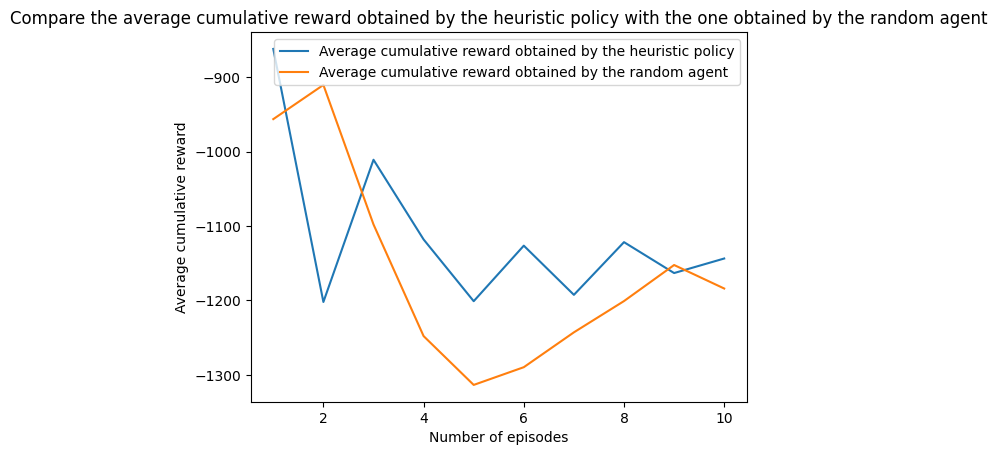

In [35]:
env = gym.make("Pendulum-v1")
num_episode=10
# Part 3: Report the average cumulative reward obtained by the heuristic policy
# draw plot to compare the average cumulative reward obtained by the heuristic policy 
# with the reward of the random agent
list_average_reward_HeuristicAgent=[]
total_episodes_reward_HeuristicAgent = 0
for episode in range(num_episode):
    agent = HeuristicPendulumAgent(env)
    total_reward_per_episode=DoEpisode(env, agent,agent.get_agent_name())
    total_episodes_reward_HeuristicAgent += total_reward_per_episode
    print('total_reward:', total_episodes_reward_HeuristicAgent)
    average_reward = total_episodes_reward_HeuristicAgent / (episode + 1)
    print('average_reward:', average_reward)
    list_average_reward_HeuristicAgent.append(average_reward)

list_average_reward_RandomAgent=[]
total_episodes_reward_RandomAgent = 0
for episode in range(num_episode):
    agent = RandomAgent(env)
    total_reward_per_episode=DoEpisode(env, agent)
    total_episodes_reward_RandomAgent += total_reward_per_episode
    print('total_reward:', total_episodes_reward_RandomAgent)
    average_reward = total_episodes_reward_RandomAgent / (episode + 1)
    print('average_reward:', average_reward)
    list_average_reward_RandomAgent.append(average_reward)

list_number_episodes = np.linspace(1,10,num=10)

plt.plot(list_number_episodes,list_average_reward_HeuristicAgent,label= 'Average cumulative reward obtained by the heuristic policy')
plt.plot(list_number_episodes,list_average_reward_RandomAgent,label= 'Average cumulative reward obtained by the random agent')
plt.xlabel('Number of episodes')
plt.ylabel('Average cumulative reward')
plt.legend()
plt.title('Compare the average cumulative reward obtained by the heuristic policy with the one obtained by the random agent')
plt.show()
env.close()

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
total_reward: -1179.4882198619214
average_reward: -1179.4882198619214
total_reward: -2147.5814946417913
average_reward: -1073.7907473208957
total_reward: -3330.6458035709397
average_reward: -1110.2152678569798
total_reward: -3844.207666281934
average_reward: -961.0519165704835
total_reward: -5136.213379810758
average_reward: -1027.2426759621517
total_reward: -6318.184906201127
average_reward: -1053.0308177001878
total_reward: -7181.01644246352
average_reward: -1025.8594917805028
total_reward: -8356.694165376919
average_reward: -1044.5867706721149
total_reward: -9545.405766613167
average_reward: -1060.6006407347963
total_reward: -10872.473400988714
average_reward: -1087.2473400988715
total_reward: -744.6285532028689
average_reward: -744.6285532028689
total_reward: -1816.5170236553415
average_reward: -908.2585118276708
total_reward: -2893.3828174347013
average_reward: -964.4609391449004
total_reward: -3516

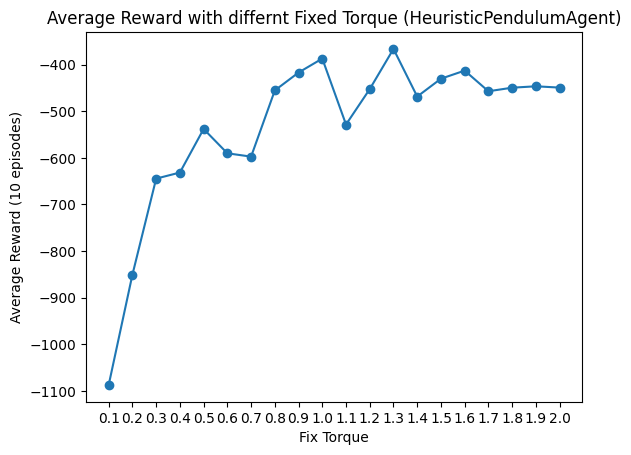

In [36]:
# Part 3: Report the average cumulative reward obtained by the heuristic policy
# draw plot to show the impact of different amplitude of the fixed torque have on the reward
env = gym.make("Pendulum-v1")
num_episode=10
list_last_average_reward=[]
list_fix_torque=np.linspace(0.1, 2.0, num=20)
print(list_fix_torque)
for fix_torque in list_fix_torque:
    total_episodes_reward_HeuristicAgent=0
    for episode in range(num_episode):
        agent = HeuristicPendulumAgent(env)
        total_reward_per_episode=DoEpisode(env,agent,agent.get_agent_name(),fix_torque)
        total_episodes_reward_HeuristicAgent += total_reward_per_episode
        print('total_reward:', total_episodes_reward_HeuristicAgent)
        average_reward = total_episodes_reward_HeuristicAgent / (episode + 1)
        print('average_reward:', average_reward)
    list_last_average_reward.append(average_reward)
plt.plot(list_fix_torque,list_last_average_reward,'-o')
plt.xlabel("Fix Torque")
plt.ylabel("Average Reward (10 episodes)")
plt.title('Average Reward with differnt Fixed Torque (HeuristicPendulumAgent)')
plt.xticks(list_fix_torque)
plt.show()
env.close()

In [37]:
import gym
env = gym.make("Pendulum-v1")
observation, info = env.reset(seed=42)

for _ in range(10):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print('observation:',observation)
    print('reward:',reward)
    print(np.append(observation,reward))
    if terminated or truncated:
        observation, info = env.reset()
env.close()

observation: [-0.169101    0.98559874  0.38794333]
reward: -2.966803692949857
[-0.169101    0.98559874  0.38794333 -2.96680369]
observation: [-0.23837419  0.9711734   1.4154797 ]
reward: -3.048829524693669
[-0.23837419  0.97117341  1.41547966 -3.04882952]
observation: [-0.3523751   0.93585885  2.3883266 ]
reward: -3.484502378211582
[-0.35237509  0.93585885  2.38832664 -3.48450238]
observation: [-0.48636916  0.8737534   2.9564342 ]
reward: -4.299596584981443
[-0.48636916  0.87375343  2.95643425 -4.29959658]
observation: [-0.64554805  0.7637197   3.8762238 ]
reward: -5.198260055306292
[-0.64554805  0.76371968  3.8762238  -5.19826006]
observation: [-0.8049193  0.5933843  4.675975 ]
reward: -6.669225022682118
[-0.8049193   0.59338433  4.67597485 -6.66922502]
observation: [-0.92693776  0.37521517  5.01256   ]
reward: -8.46871599296393
[-0.92693776  0.37521517  5.01255989 -8.46871599]
observation: [-0.99437577  0.10590952  5.5704074 ]
reward: -10.116821294091741
[ -0.99437577   0.10590952   

## 4. Q function of the heuristic policy 

In [42]:
import random
# Implement the Replay Buffer
class ReplayBuffer():
    def __init__(self, max_size):
        # max_size: how many transitions replay buffer can store at most
        self.max_size = max_size
        self.total_transition = []

    def add(self, transition):
        # transition: a tuple of (state, action, reward, next_state, trunc)

        # check if the replay buffer is full
        if len(self.total_transition) >= self.max_size:
            print("The replay buffer is full.-> remove the oldest transition")
            # remove the oldest transition
            self.total_transition.pop(0)
        # add transition to replay buffer
        self.total_transition.append(transition)
        
    def sample(self, batch_size):
        # batch_size: how many transitions will be sampled
        # return a batch of transitions
        
        # check if the replay buffer is empty
        if len(self.total_transition) == 0:
            print("The replay buffer is empty.")
            return None
        
        # check if the replay buffer has enough transitions
        if len(self.total_transition) < batch_size:
            print("The replay buffer does not have enough transitions.")
            return None
        
        # sample batch_size transitions from the replay buffer randomly
        return random.sample(self.total_transition, batch_size)

In [39]:
# Implement the class QNetwork
class QNetwork(nn.Module):
    def __init__(self, input_dim=4, output_dim=1, hidden_dim=32):
        super(QNetwork, self).__init__()
        # input_dim: dimension of the input -> 3 elements of the state and 1 of the action
        # hidden_dim: dimension of one hidden layer -> 32 nodes
        # output_dim: dimension of action -> a scalar value (the expected cumulative reward)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        # state: state -> 3 elements of the state and 1 of the action
        # return expected cumulative reward 
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x   

In [40]:
# Implement the 1-step TD-learning rule for the QNetwork
def train(Q_network, Q_target,agent, replay_buffer, gamma, optimizer, batch_size,fix_torque=0.1):
    # print("HERE TRAIN")
    # Q_network: Q Network
    # Q_target: target Q network
    # agent: policy use for action selection
    # replay_buffer: replay buffer
    # gamma: discount factor
    # optimizer: optimizer
    # batch_size: batch size
    # fix_torque: fixed torque for HeuristicPendulumAgent
    
    # sample a batch of transitions from the replay buffer
    batch = replay_buffer.sample(batch_size)
    
    # unpack the batch of transitions
    # input_batch:put together 3 elements of the state and 1 of the action
    input_batch=torch.tensor([np.append(transition[0],transition[1]) for transition in batch], dtype=torch.float32)
    action_batch=torch.tensor([transition[1] for transition in batch], dtype=torch.float32)
    reward_batch = torch.tensor([transition[2] for transition in batch], dtype=torch.float32)
    target_batch=torch.tensor([np.append(transition[3], agent.compute_action(transition[3],fix_torque)) for transition in batch], dtype=torch.float32)
    next_state_batch = torch.tensor([transition[3] for transition in batch], dtype=torch.float32)
    trunc_batch = torch.tensor([transition[4] for transition in batch], dtype=torch.float32)

    # compute the Q values of the current state + action pair
    Q_values = Q_network(input_batch)
    
    # The target should not be differentiated, i.e., wrap it in a with torch.no grad()
    with torch.no_grad():
        # compute the Q values of the next state + action pair
        Q_next_values = Q_target(target_batch)
        # compute the target Q values
        Q_target_values = reward_batch + gamma * Q_next_values.max(1)[0] * (1 - trunc_batch)
    
    # compute the loss
    loss = F.mse_loss(Q_values.view(-1, 1), Q_target_values.view(-1, 1))
    
    # clear the gradients of the optimizer
    optimizer.zero_grad()
    
    # compute the gradients of the loss
    loss.backward()
    
    # update the weights of the Q network
    optimizer.step()
    
    return loss.item()

episode number: 0 / 1000 ...
episode number: 1 / 1000 ...
episode number: 2 / 1000 ...
episode number: 3 / 1000 ...
episode number: 4 / 1000 ...
episode number: 5 / 1000 ...
episode number: 6 / 1000 ...
episode number: 7 / 1000 ...
episode number: 8 / 1000 ...
episode number: 9 / 1000 ...
episode number: 10 / 1000 ...
episode number: 11 / 1000 ...
episode number: 12 / 1000 ...
episode number: 13 / 1000 ...
episode number: 14 / 1000 ...
episode number: 15 / 1000 ...
episode number: 16 / 1000 ...
episode number: 17 / 1000 ...
episode number: 18 / 1000 ...
episode number: 19 / 1000 ...
episode number: 20 / 1000 ...
episode number: 21 / 1000 ...
episode number: 22 / 1000 ...
episode number: 23 / 1000 ...
episode number: 24 / 1000 ...
episode number: 25 / 1000 ...
episode number: 26 / 1000 ...
episode number: 27 / 1000 ...
episode number: 28 / 1000 ...
episode number: 29 / 1000 ...
episode number: 30 / 1000 ...
episode number: 31 / 1000 ...
episode number: 32 / 1000 ...
episode number: 33 /

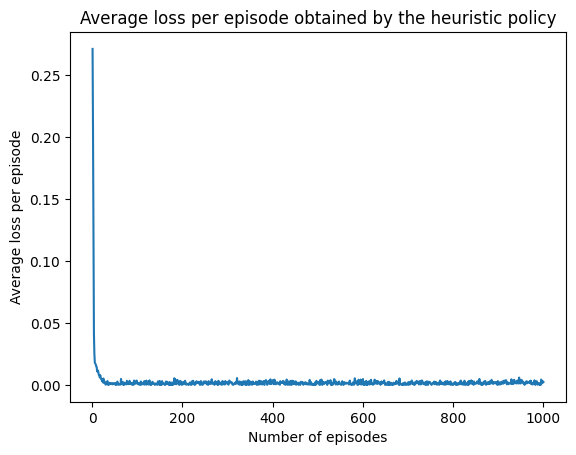

In [49]:
# Write a loop in which the HeuristicPendulumAgent collects experience and stores it in the replay
# buffer. At each step, sample a batch of transitions from the replay buffer (uniformly at random,
# batch size 128) and feed them to the 1-step TD-learning rule that you have implemented. At each
# step, store the loss of the Q network. 
import copy
env = gym.make("Pendulum-v1")
num_episode=1000
batch_size=128
buffer_size=10000
gamma=0.99
learning_rate=1e-4
sum_loss=0
list_average_loss=[]
# initialize the Q network and the target Q network
Q_network=QNetwork()
Q_target=QNetwork()
# define a optimizer for the QNetwork
optimizer = torch.optim.Adam(Q_network.parameters(), learning_rate)
# define replay buffer
replay_buffer=ReplayBuffer(buffer_size)
# define agent
agent = HeuristicPendulumAgent(env)
num_step=200

state, info = env.reset()
for _ in range(buffer_size):
    action = agent.compute_action(observation,fix_torque)
    # print('action:',action)
    normalized_env = NormalizedEnv(env)
    normalized_action = normalized_env.action(action)
    # print('normalized_action:',normalized_action)
    next_state, reward, terminated, truncated, info = env.step(normalized_action)
    transition=(state, normalized_action, reward, next_state, truncated)
    replay_buffer.add(transition)
    state=next_state

for episode in range(num_episode):
    print('episode number:',episode,'/',num_episode,'...')
    for step in range(num_step):
        # print('step:',step,'/',num_step,'...')
        loss=train(Q_network, Q_target,agent, replay_buffer, gamma, optimizer, batch_size)
        # print('loss:',loss)
        Q_target=copy.deepcopy(Q_network)
        sum_loss=+loss
    average_loss=sum_loss/num_step
    list_average_loss.append(average_loss)
print('Finishing training!')
print('Save the model...')
# save the model with path name with real-time date and time
save_path= os.path.join('trained_model','Q_network_heuristic_policy_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'_ep'+str(num_episode)+'.pth')
torch.save(Q_network.state_dict(), save_path)
print('Model save to ',save_path,' !')

list_number_episodes = np.linspace(1,num_episode,num = num_episode)
plt.plot(list_number_episodes,list_average_loss)
plt.xlabel('Number of episodes')
plt.ylabel('Average loss per episode')
plt.title('Average loss per episode obtained by the heuristic policy')
print('Save the figure...')
image_path=os.path.join('figure','4_TrainingCruveofQnetwork_ep'+str(num_episode)+'.png')
plt.savefig(image_path)
plt.show()
env.close()


In [ ]:
Q_network=QNetwork()
state, info = env.reset()
for _ in range(buffer_size):
    action = agent.compute_action(observation,fix_torque)
    # print('action:',action)
    normalized_env = NormalizedEnv(env)
    normalized_action = normalized_env.action(action)
    # print('normalized_action:',normalized_action)
    next_state, reward, terminated, truncated, info = env.step(normalized_action)
    transition=(state, normalized_action, reward, next_state, truncated)
    replay_buffer.add(transition)
    state=next_state
    
# sample a batch of transitions from the replay buffer
batch = replay_buffer.sample(batch_size)
 # unpack the batch of transitions
# input_batch:put together 3 elements of the state and 1 of the action
input_batch=torch.tensor([np.append(transition[0],transition[1]) for transition in batch], dtype=torch.float32)

# compute the Q values of the current state + action pair
Q_values = Q_network(input_batch)



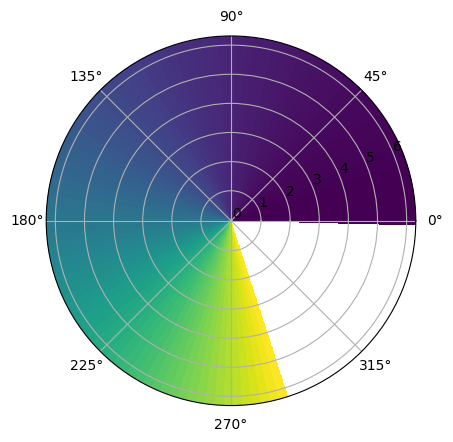

In [ ]:
ax = Axes3D(plt.figure())
rad=np.linspace(0,5,100)
azm=np.linspace(0,2*np.pi,100)
r,th=np.meshgrid(rad,azm)
z=(r**2.0)/4.0
plt.subplot(projection="polar")
plt.pcolormesh(r,th, z)
plt.show()